# PCB Thermography Analysis Program
### Objective
This program is designed to process PCB thermography images (both radiometric `.tif` and non-radiometric `.jpg`/`.png` formats). The workflow involves:
1. Loading and displaying the thermography image.
2. Selecting and centering the PCB by defining the corners.
3. Defining emissivity shapes (circles, quadrilaterals).
4. Calibrating the image based on emissivity and temperature data.

The program adapts to both `.tif` (radiometric) images and non-radiometric RGB images (`.jpg`, `.png`).

---


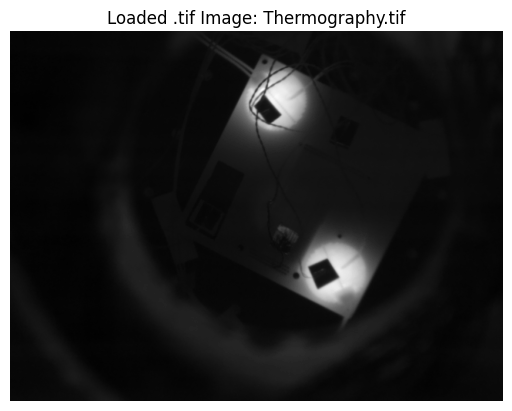

Image Thermography.tif loaded and displayed successfully.


In [1]:
# Import necessary modules and functions
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Import the image processing module
from image_processing import load_and_display_image, select_corners_jpg, select_corners_tif
import emissivity_processing as ep
import calibration_processing as cp


# Ask the user for the image file name (including extension)
image_name = input("Please enter the image name with extension (e.g., image.jpg or image.tif): ")

# Call the function to load and display the image
image = load_and_display_image(image_name)

# Check if the image was successfully loaded
if image is not None:
    print(f"Image {image_name} loaded and displayed successfully.")
else:
    print(f"Failed to load the image {image_name}.")


## Procesamos la imagen

Convirtiendo la imagen de modo 'F' a 'L' (escala de grises) para generar .png
Seleccione 4 esquinas del PCB haciendo clic en la imagen.
Esquinas seleccionadas: [(324, 28), (557, 124), (446, 373), (207, 260)]


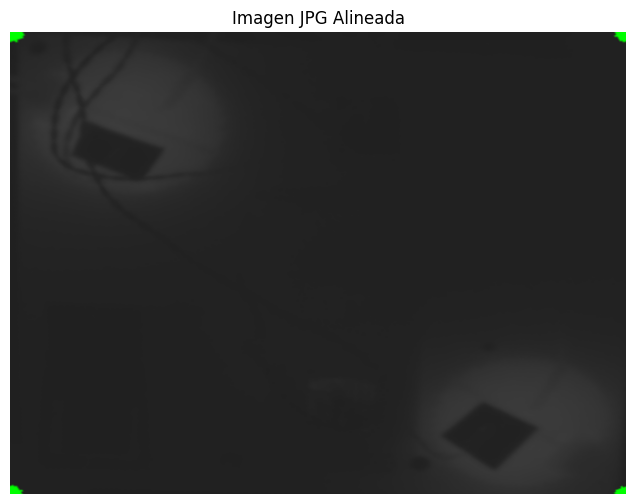

Imagen .tif alineada y transformada.


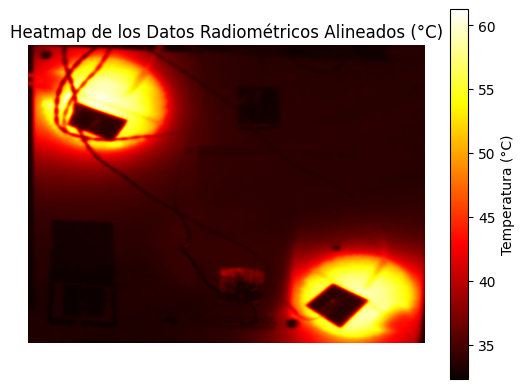

In [2]:
# Definir la ruta completa de la imagen
image_path = os.path.join("Images", image_name)

# Comprobar la extensión de la imagen (.jpg/.png o .tif)
extension = image_name.split('.')[-1].lower()

# Bandera para saber si estamos procesando un .tif
is_tif = False

if extension in ['jpg', 'png']:
    # Si es .jpg o .png, seleccionar esquinas, alinear la imagen y calcular la matriz de temperatura RGB
    aligned_image_jpg, temperature_matrix_jpg, corners = select_corners_jpg(cv2.imread(image_path))
    
    # print("Imagen .jpg/.png alineada y transformada.")
    # plt.imshow(cv2.cvtColor(aligned_image_jpg, cv2.COLOR_BGR2RGB))
    # plt.title("Imagen Alineada")
    # plt.axis('off')
    # plt.show()

    # Imprimir un tramo de la matriz RGB para asegurar que no está en escala de grises
    print("Tramo de la matriz RGB de la imagen JPG:")
    print(temperature_matrix_jpg[:5, :5, :])  # Imprimir los primeros 5x5 elementos de la matriz RGB

elif extension == 'tif':
    # Si es .tif, activar la bandera para evitar el procesamiento RGB
    is_tif = True

    # Generar un .jpg temporal para la selección de esquinas
    temp_png_path = "Images/temp_image.png"
    aligned_visual_tif, aligned_radiometric_data = select_corners_tif(image_path, cv2.imread(image_path, cv2.IMREAD_UNCHANGED), temp_png_path)

    print("Imagen .tif alineada y transformada.")

    # Mostrar el heatmap de los datos radiométricos con la escala adecuada
    plt.imshow(aligned_radiometric_data, cmap='hot')
    plt.colorbar(label="Temperatura (°C)")  # Cambia 'Escala relativa' a la unidad adecuada
    plt.title("Heatmap de los Datos Radiométricos Alineados (°C)")
    plt.axis('off')
    plt.show()



else:
    print("Formato de archivo no soportado. Solo se soportan archivos .jpg, .png y .tif.")

## Calibramos la emissividad

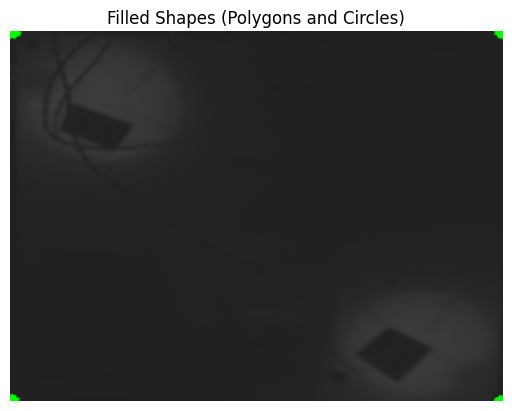

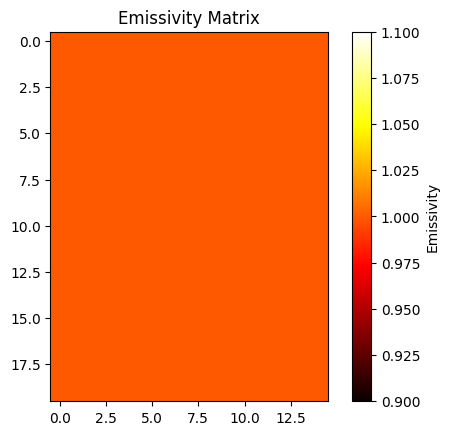


Emissivity information for defined shapes:


In [3]:
base_emissivity = float(input("Enter the base emissivity value for the PCB: "))

# Pass the correct image based on the extension
if extension in ['jpg', 'png']:
    emissivity_matrix = ep.process_emissivity(aligned_image_jpg, base_emissivity)
elif extension == 'tif':
    emissivity_matrix = ep.process_emissivity(aligned_visual_tif, base_emissivity)

## Calibramos la temperatura final

Dimensiones de los datos radiométricos: (480, 640)
Dimensiones de la matriz de emisividad: (20, 15)
Matriz de temperatura calibrada (primeros 5x5 valores):
[[33.37867  33.372585 33.371758 33.37357  33.435257]
 [33.288834 33.312607 33.310387 33.313354 33.37025 ]
 [33.17674  33.225212 33.259373 33.312218 33.40767 ]
 [33.09247  33.13833  33.178703 33.27389  33.406105]
 [33.030018 33.065353 33.103695 33.20058  33.417336]]


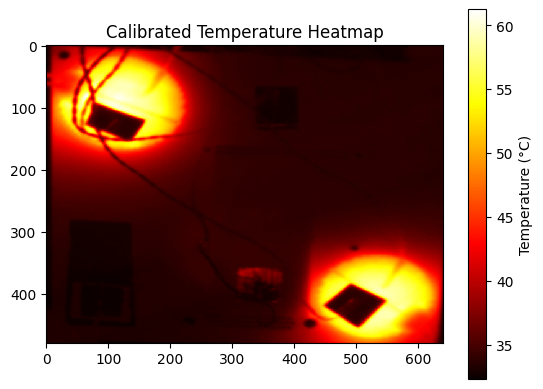

In [4]:
m, n = 20, 15  # Define the grid size

if extension == 'jpg':
    # Call the calibration function (initial step: just RGB-based heatmap)
    calibrated_temperature_matrix = cp.calibrate_temperature('jpg', aligned_image_jpg, temperature_matrix_jpg, emissivity_matrix, m, n)

elif extension == 'tif':
    # Continue as before with the .tif calibration
    calibrated_temperature_matrix = cp.calibrate_temperature('tif', aligned_radiometric_data, aligned_radiometric_data, emissivity_matrix, m, n)

# Visualize the temperature matrix (heatmap)
cp.visualize_temperature_matrix(calibrated_temperature_matrix)


